In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import pywt
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_9220\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0005'][0]), len(Battery['B0005'][1])

(168, 168)

## 画出数据

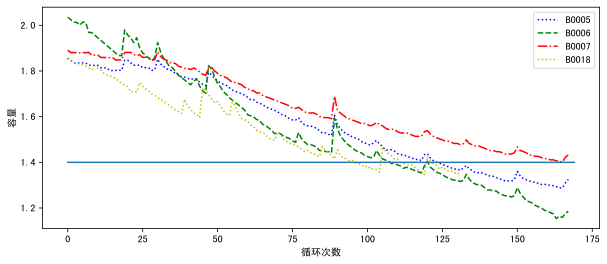

In [4]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [8]:
threshold_xi = [0.7, 0.7, 0.75, 0.7]

# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4，所以设置为1.5，即第126次循环达到阈值1.5
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    # print('y_test len is', len(y_test))
    # print('y_predict len is', len(y_predict))
    # print('threshold is', threshold)
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    # print('true_re is', true_re)
    return abs(true_re - pred_re) / true_re, abs(true_re - pred_re)

relative_error(Battery['B0005'][1], Battery['B0005'][1], 1.4)

(0.0, 0)

## 小波降噪 level=1

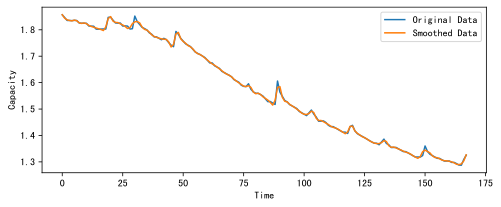

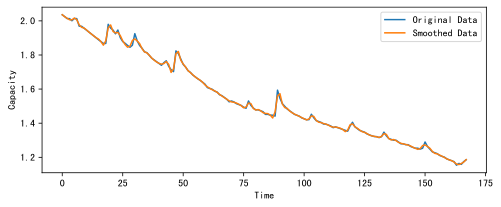

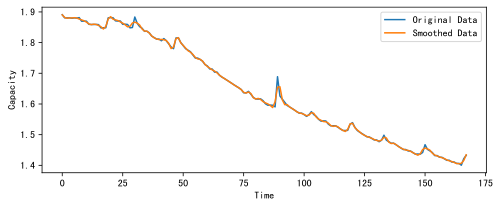

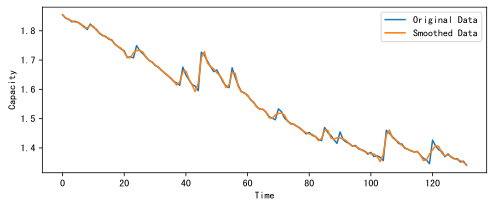

battery_index:0    , MAE:0.0030 , RMSE:0.0049 , RE:0.0000
battery_index:1    , MAE:0.0047 , RMSE:0.0077 , RE:0.0000
battery_index:2    , MAE:0.0026 , RMSE:0.0049 , RE:0.0000
battery_index:3    , MAE:0.0054 , RMSE:0.0084 , RE:0.0000
4


In [10]:
# 小波降噪函数
def wavelet_smoothing(data, wavelet='db4', level=1):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.5
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]), mode='soft')
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

wd_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data

    smoothed_data = wavelet_smoothing(original_data)
    wd_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 小波降噪后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, wd_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re, ae = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

print(len(wd_battery_data_list))

## 构建训练序列数据

In [11]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size
# train_y 的维度是 window_size
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data = data_sequence[startPreIndex: window_size + startPreIndex]
    test_data = data_sequence[startPreIndex + window_size:]
    
    current_battery_train_data = data_sequence[:startPreIndex]
    # print('current_battery_train_data', len(current_battery_train_data))
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            # print('len(data_x)', len(data_x))
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                
    data_x, data_y = build_seq(text=current_battery_train_data, window_size=window_size)
    # print('data_x len is', len(data_x))
    if (len(data_x) > 0):
        train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [12]:
startPreIndex = 50

train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, 3, window_size=64)
print('train_data len is', len(train_data))
print('test_data len is', len(test_data))
# train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)

train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

train_data len is 64
test_data len is 18
torch.Size([2, 64])
torch.Size([2, 64])
tensor([[1.8571, 1.8439, 1.8376, 1.8352, 1.8337, 1.8367, 1.8342, 1.8263, 1.8240,
         1.8260, 1.8231, 1.8166, 1.8125, 1.8098, 1.8066, 1.8041, 1.8010, 1.7972,
         1.8107, 1.8429, 1.8498, 1.8327, 1.8278, 1.8272, 1.8224, 1.8183, 1.8125,
         1.8048, 1.8081, 1.8232, 1.8302, 1.8313, 1.8262, 1.8105, 1.8016, 1.7987,
         1.7908, 1.7808, 1.7746, 1.7714, 1.7681, 1.7656, 1.7643, 1.7636, 1.7542,
         1.7349, 1.7448, 1.7845, 1.7899, 1.7659, 1.7558, 1.7489, 1.7402, 1.7356,
         1.7275, 1.7164, 1.7096, 1.7064, 1.7005, 1.6929, 1.6856, 1.6776, 1.6708,
         1.6655],
        [1.8439, 1.8376, 1.8352, 1.8337, 1.8367, 1.8342, 1.8263, 1.8240, 1.8260,
         1.8231, 1.8166, 1.8125, 1.8098, 1.8066, 1.8041, 1.8010, 1.7972, 1.8107,
         1.8429, 1.8498, 1.8327, 1.8278, 1.8272, 1.8224, 1.8183, 1.8125, 1.8048,
         1.8081, 1.8232, 1.8302, 1.8313, 1.8262, 1.8105, 1.8016, 1.7987, 1.7908,
         1

## 绘制 out 和  tgt_y的对比图

In [13]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络 实现多层

In [15]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, kernel_size=3, strides=1):
        super().__init__()
        
        hidden_dim = input_channels * 2
        
        self.conv1 = nn.Conv1d(input_channels, hidden_dim, kernel_size=kernel_size, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=strides, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim, input_channels, kernel_size=kernel_size, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(input_channels)

    def forward(self, X):
        conv1_out = self.conv1(X)
        # print('conv1_out shape is', conv1_out.shape)

        bn1_out = self.bn1(conv1_out)
        # print('bn1_out shape is', bn1_out.shape)

        relu1_out = F.relu(bn1_out)
        # print('relu1_out shape is', relu1_out.shape)

        conv2_out = self.conv2(relu1_out)
        # print('conv2_out shape is', conv2_out.shape)

        bn2_out = self.bn2(conv2_out)
        # print('bn2_out shape is', bn2_out.shape)

        relu2_out = F.relu(bn2_out)
        # print('relu2_out shape is', relu2_out.shape)

        conv3_out = self.conv3(relu2_out)
        # print('conv3_out shape is', conv3_out.shape)

        bn3_out = self.bn3(conv3_out)
        # print('bn3_out shape is', bn3_out.shape)


        Y = X + bn3_out
        # print('Y shape is', Y.shape)
        return F.relu(Y)

def resnet_block(input_channels, num_layers=2, kernel_size=3):
    blk = []
    for i in range(num_layers):
        blk.append(Residual1D(input_channels=input_channels, kernel_size=kernel_size))
    return blk
    
res_blks = resnet_block(32, 2)
X = torch.rand(50, 32, 16) # 50是批次大小，32是d_model，16是窗口大小
blks_model = nn.Sequential(*res_blks)
Y = blks_model(X)
Y.shape

torch.Size([50, 32, 16])

## 随机种子

In [16]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 位置编码

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## 搭建模型 此处代码是模板 无需运行

In [73]:
class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        # x = x.reshape(x.shape[0], x.shape[1], 1)
        x = x.reshape(x.shape[0], 1, x.shape[1])
        
        # x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状 此处代码是模板 无需运行

In [74]:
# 测试模型的输出形状
net = Net(d_model=16).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 1, 1])


## 一个批次的训练函数

In [18]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
 
        out = net(x)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [19]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(rmse_epoch_list) == 0 or (rmse_epoch_list[-1] < rmse)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [20]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x / Rated_Capacity, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        pred_next_point = pred.cpu().data.numpy()[-1] * Rated_Capacity
        
        pre_list.append(pred_next_point)
        
    return pre_list

## 以网格搜索出来的模型最优参数进行B0005实验 以rmse评价指标为判断函数

In [22]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [32]
nhead_list = [4]
num_encoder_layers_list = [2]
dim_feedforward_list = [32]
kernel_size = 3
num_res_layers_list = [4]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 80
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in d_model_list:
    for nhead in nhead_list:
        for num_encoder_layers in num_encoder_layers_list:
            for dim_feedforward in dim_feedforward_list:
                for num_res_layers in num_res_layers_list:
                    for seed in range(10):
                        main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:0, 测试集:B0005, epoch:1   , loss:1.2053054571, MAE:1.8395, RMSE:1.8403, RE:0.2320, AE:29.0000, R2:-818.6699, currentSum:0.0000
seed:0, 测试集:B0005, epoch:2   , loss:0.5896579027, MAE:1.5720, RMSE:1.5731, RE:0.2320, AE:29.0000, R2:-597.9254, currentSum:1.5731
seed:0, 测试集:B0005, epoch:3   , loss:0.2966067493, MAE:1.2109, RMSE:1.2117, RE:0.2320, AE:29.0000, R2:-354.3186, currentSum:1.2117
seed:0, 测试集:B0005, epoch:4   , loss:0.0933836475, MAE:0.7042, RMSE:0.7085, RE:0.2320, AE:29.0000, R2:-120.4775, currentSum:0.7085
seed:0, 测试集:B0005, epoch:5   , loss:0.0407250822, MAE:0.1600, RMSE:0.1671, RE:0.2320, AE:29.0000, R2:-5.7582, currentSum:0.1671
seed:0, 测试集:B0005, epoch:9   , loss:0.0170610100, MAE:0.0499, RMSE:0.0591, RE:0.3440, AE:43.0000, R2:0.1534, currentSum:0

seed:2, 测试集:B0005, epoch:257 , loss:0.0003887228, MAE:0.0165, RMSE:0.0200, RE:0.0720, AE:9.0000, R2:0.9037, currentSum:0.0200
seed:2, 测试集:B0005, epoch:307 , loss:0.0003597684, MAE:0.0114, RMSE:0.0154, RE:0.0480, AE:6.0000, R2:0.9425, currentSum:0.0154
seed:2, 测试集:B0005, epoch:319 , loss:0.0003211774, MAE:0.0088, RMSE:0.0123, RE:0.0320, AE:4.0000, R2:0.9635, currentSum:0.0123
---------------------------------
re_s [0.032]
ae_s [4]
---------------------------------
re min: 0.032
ae min: 4
mae min: 0.008750217193737482
rmse min: 0.012282238730423039
r2 max: 0.9634902328726835
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0005 为测试数据的 数据集 开始训练
seed:3, 测试集:B0005, epoch:1   , loss:1.9603073597, MAE:2.0153, RMSE:2.0195, RE:0.2320, AE:29.0000, R2:-986.0654, currentSum:0.0000
seed:3, 测试集:B0005, epoch:

seed:6, 测试集:B0005, epoch:1   , loss:1.1021685600, MAE:1.5667, RMSE:1.5711, RE:0.2320, AE:29.0000, R2:-596.4108, currentSum:0.0000
seed:6, 测试集:B0005, epoch:2   , loss:0.5577278137, MAE:1.5326, RMSE:1.5357, RE:0.2320, AE:29.0000, R2:-569.7536, currentSum:1.5357
seed:6, 测试集:B0005, epoch:3   , loss:0.2961838543, MAE:1.2752, RMSE:1.2788, RE:0.2320, AE:29.0000, R2:-394.7543, currentSum:1.2788
seed:6, 测试集:B0005, epoch:4   , loss:0.1010362655, MAE:0.7925, RMSE:0.8098, RE:0.2320, AE:29.0000, R2:-157.7122, currentSum:0.8098
seed:6, 测试集:B0005, epoch:5   , loss:0.0394213870, MAE:0.1418, RMSE:0.1555, RE:0.3440, AE:43.0000, R2:-4.8496, currentSum:0.1555
seed:6, 测试集:B0005, epoch:51  , loss:0.0035684649, MAE:0.0739, RMSE:0.0845, RE:0.1440, AE:18.0000, R2:-0.7294, currentSum:0.0845
seed:6, 测试集:B0005, epoch:54  , loss:0.0030037458, MAE:0.0678, RMSE:0.0789, RE:0.1360, AE:17.0000, R2:-0.5074, currentSum:0.0789
seed:6, 测试集:B0005, epoch:64  , loss:0.0025928956, MAE:0.0578, RMSE:0.0639, RE:0.1120, AE:14.0000

seed:9, 测试集:B0005, epoch:24  , loss:0.0034260703, MAE:0.0433, RMSE:0.0495, RE:0.1760, AE:22.0000, R2:0.4077, currentSum:0.0495
seed:9, 测试集:B0005, epoch:25  , loss:0.0027954623, MAE:0.0414, RMSE:0.0479, RE:0.1760, AE:22.0000, R2:0.4436, currentSum:0.0479
seed:9, 测试集:B0005, epoch:26  , loss:0.0027036287, MAE:0.0400, RMSE:0.0465, RE:0.1760, AE:22.0000, R2:0.4772, currentSum:0.0465
seed:9, 测试集:B0005, epoch:34  , loss:0.0020298897, MAE:0.0218, RMSE:0.0254, RE:0.0640, AE:8.0000, R2:0.8437, currentSum:0.0254
seed:9, 测试集:B0005, epoch:50  , loss:0.0022317541, MAE:0.0191, RMSE:0.0225, RE:0.0480, AE:6.0000, R2:0.8773, currentSum:0.0225
seed:9, 测试集:B0005, epoch:75  , loss:0.0007672546, MAE:0.0171, RMSE:0.0200, RE:0.0720, AE:9.0000, R2:0.9028, currentSum:0.0200
seed:9, 测试集:B0005, epoch:96  , loss:0.0004913814, MAE:0.0152, RMSE:0.0180, RE:0.0560, AE:7.0000, R2:0.9215, currentSum:0.0180
seed:9, 测试集:B0005, epoch:107 , loss:0.0004291180, MAE:0.0102, RMSE:0.0135, RE:0.0400, AE:5.0000, R2:0.9560, current

## 以网格搜索出来的模型最优参数进行B0006、B0007实验 以rmse评价指标为判断函数

In [24]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [32]
nhead_list = [4]
num_encoder_layers_list = [2]
dim_feedforward_list = [32]
kernel_size = 3
num_res_layers_list = [4]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 80
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(1, 3):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in d_model_list:
    for nhead in nhead_list:
        for num_encoder_layers in num_encoder_layers_list:
            for dim_feedforward in dim_feedforward_list:
                for num_res_layers in num_res_layers_list:
                    for seed in range(10):
                        main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0006 为测试数据的 数据集 开始训练
seed:0, 测试集:B0006, epoch:1   , loss:1.2076274157, MAE:1.7800, RMSE:1.7816, RE:0.1193, AE:13.0000, R2:-439.9272, currentSum:0.0000
seed:0, 测试集:B0006, epoch:2   , loss:0.5986535549, MAE:1.5047, RMSE:1.5069, RE:0.1193, AE:13.0000, R2:-314.4155, currentSum:1.5069
seed:0, 测试集:B0006, epoch:3   , loss:0.2924249470, MAE:1.1367, RMSE:1.1386, RE:0.1193, AE:13.0000, R2:-179.0741, currentSum:1.1386
seed:0, 测试集:B0006, epoch:4   , loss:0.0930857807, MAE:0.6106, RMSE:0.6168, RE:0.1193, AE:13.0000, R2:-51.8423, currentSum:0.6168
seed:0, 测试集:B0006, epoch:5   , loss:0.0406292900, MAE:0.1044, RMSE:0.1202, RE:0.1193, AE:13.0000, R2:-1.0069, currentSum:0.1202
seed:0, 测试集:B0006, epoch:15  , loss:0.0113839619, MAE:0.0818, RMSE:0.1071, RE:0.0275, AE:3.0000, R2:-0.5922, currentSum:0.

seed:1, 测试集:B0007, epoch:201 , loss:0.0007406056, MAE:0.0094, RMSE:0.0105, RE:0.0238, AE:3.0000, R2:0.9605, currentSum:0.0105
seed:1, 测试集:B0007, epoch:251 , loss:0.0043922244, MAE:0.0078, RMSE:0.0101, RE:0.0000, AE:0.0000, R2:0.9635, currentSum:0.0101
seed:1, 测试集:B0007, epoch:271 , loss:0.0011442400, MAE:0.0076, RMSE:0.0095, RE:0.0159, AE:2.0000, R2:0.9673, currentSum:0.0095
seed:1, 测试集:B0007, epoch:280 , loss:0.0003470172, MAE:0.0066, RMSE:0.0095, RE:0.0159, AE:2.0000, R2:0.9675, currentSum:0.0095
---------------------------------
re_s [0.01834862385321101, 0.015873015873015872]
ae_s [2, 2]
---------------------------------
re min: 0.015873015873015872
ae min: 2
mae min: 0.006614611059425036
rmse min: 0.009500303965714692
r2 max: 0.9675333240707266
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以

seed:2, 测试集:B0007, epoch:222 , loss:0.0017717048, MAE:0.0130, RMSE:0.0166, RE:0.0476, AE:6.0000, R2:0.9012, currentSum:0.0166
seed:2, 测试集:B0007, epoch:262 , loss:0.0004227081, MAE:0.0075, RMSE:0.0097, RE:0.0079, AE:1.0000, R2:0.9663, currentSum:0.0097
---------------------------------
re_s [0.009174311926605505, 0.007936507936507936]
ae_s [1, 1]
---------------------------------
re min: 0.007936507936507936
ae min: 1
mae min: 0.007547984726408105
rmse min: 0.009684027025277707
r2 max: 0.9662654586647534
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0006 为测试数据的 数据集 开始训练
seed:3, 测试集:B0006, epoch:1   , loss:1.9665150642, MAE:1.9496, RMSE:1.9549, RE:0.1193, AE:13.0000, R2:-529.8688, currentSum:0.0000
seed:3, 测试集:B0006, epoch:2   , loss:1.0492255688, MAE:1.5953, RMSE:1.6003, RE:0.1193, AE:13.0000

以电池 B0007 为测试数据的 数据集 开始训练
seed:4, 测试集:B0007, epoch:1   , loss:0.1016836017, MAE:1.1938, RMSE:1.1947, RE:0.2381, AE:30.0000, R2:-512.4384, currentSum:0.0000
seed:4, 测试集:B0007, epoch:2   , loss:0.0628841221, MAE:0.6725, RMSE:0.6758, RE:0.2381, AE:30.0000, R2:-163.2897, currentSum:0.6758
seed:4, 测试集:B0007, epoch:3   , loss:0.0462107919, MAE:0.3456, RMSE:0.3518, RE:0.2381, AE:30.0000, R2:-43.5093, currentSum:0.3518
seed:4, 测试集:B0007, epoch:4   , loss:0.0369123109, MAE:0.2344, RMSE:0.2460, RE:0.2381, AE:30.0000, R2:-20.7703, currentSum:0.2460
seed:4, 测试集:B0007, epoch:5   , loss:0.0301815029, MAE:0.0262, RMSE:0.0315, RE:0.0635, AE:8.0000, R2:0.6433, currentSum:0.0315
seed:4, 测试集:B0007, epoch:147 , loss:0.0004306464, MAE:0.0252, RMSE:0.0292, RE:0.0556, AE:7.0000, R2:0.6943, currentSum:0.0292
seed:4, 测试集:B0007, epoch:153 , loss:0.0005321730, MAE:0.0220, RMSE:0.0262, RE:0.0397, AE:5.0000, R2:0.7522, currentSum:0.0262
seed:4, 测试集:B0007, epoch:157 , loss:0.0021109197, MAE:0.0213, RMSE:0.0231, RE:

seed:6, 测试集:B0006, epoch:61  , loss:0.0039742636, MAE:0.0499, RMSE:0.0562, RE:0.2202, AE:24.0000, R2:0.5605, currentSum:0.0562
seed:6, 测试集:B0006, epoch:63  , loss:0.0030676958, MAE:0.0297, RMSE:0.0356, RE:0.1284, AE:14.0000, R2:0.8237, currentSum:0.0356
seed:6, 测试集:B0006, epoch:67  , loss:0.0028442736, MAE:0.0289, RMSE:0.0334, RE:0.1284, AE:14.0000, R2:0.8452, currentSum:0.0334
seed:6, 测试集:B0006, epoch:73  , loss:0.0024504995, MAE:0.0263, RMSE:0.0315, RE:0.1101, AE:12.0000, R2:0.8623, currentSum:0.0315
seed:6, 测试集:B0006, epoch:74  , loss:0.0018857864, MAE:0.0263, RMSE:0.0312, RE:0.1101, AE:12.0000, R2:0.8647, currentSum:0.0312
seed:6, 测试集:B0006, epoch:76  , loss:0.0024351685, MAE:0.0257, RMSE:0.0303, RE:0.0642, AE:7.0000, R2:0.8724, currentSum:0.0303
seed:6, 测试集:B0006, epoch:79  , loss:0.0025501626, MAE:0.0243, RMSE:0.0293, RE:0.0642, AE:7.0000, R2:0.8806, currentSum:0.0293
以电池 B0007 为测试数据的 数据集 开始训练
seed:6, 测试集:B0007, epoch:1   , loss:0.0621298552, MAE:0.5571, RMSE:0.5611, RE:0.2381, A

seed:8, 测试集:B0006, epoch:19  , loss:0.0063768337, MAE:0.0644, RMSE:0.0751, RE:0.1101, AE:12.0000, R2:0.2157, currentSum:0.0751
seed:8, 测试集:B0006, epoch:27  , loss:0.0039397478, MAE:0.0621, RMSE:0.0717, RE:0.1101, AE:12.0000, R2:0.2854, currentSum:0.0717
seed:8, 测试集:B0006, epoch:30  , loss:0.0033334699, MAE:0.0619, RMSE:0.0693, RE:0.1009, AE:11.0000, R2:0.3332, currentSum:0.0693
seed:8, 测试集:B0006, epoch:31  , loss:0.0037316708, MAE:0.0525, RMSE:0.0621, RE:0.0826, AE:9.0000, R2:0.4645, currentSum:0.0621
seed:8, 测试集:B0006, epoch:32  , loss:0.0026660401, MAE:0.0514, RMSE:0.0580, RE:0.0917, AE:10.0000, R2:0.5335, currentSum:0.0580
seed:8, 测试集:B0006, epoch:223 , loss:0.0004085611, MAE:0.0396, RMSE:0.0552, RE:0.0183, AE:2.0000, R2:0.5761, currentSum:0.0552
seed:8, 测试集:B0006, epoch:249 , loss:0.0009139084, MAE:0.0401, RMSE:0.0516, RE:0.0183, AE:2.0000, R2:0.6301, currentSum:0.0516
seed:8, 测试集:B0006, epoch:269 , loss:0.0001958410, MAE:0.0361, RMSE:0.0493, RE:0.0367, AE:4.0000, R2:0.6629, curren

seed:9, 测试集:B0006, epoch:121 , loss:0.0006484616, MAE:0.0431, RMSE:0.0544, RE:0.0459, AE:5.0000, R2:0.5894, currentSum:0.0544
seed:9, 测试集:B0006, epoch:144 , loss:0.0004710304, MAE:0.0387, RMSE:0.0527, RE:0.0183, AE:2.0000, R2:0.6142, currentSum:0.0527
seed:9, 测试集:B0006, epoch:145 , loss:0.0003984350, MAE:0.0404, RMSE:0.0517, RE:0.0275, AE:3.0000, R2:0.6281, currentSum:0.0517
seed:9, 测试集:B0006, epoch:186 , loss:0.0004629913, MAE:0.0384, RMSE:0.0513, RE:0.0183, AE:2.0000, R2:0.6343, currentSum:0.0513
seed:9, 测试集:B0006, epoch:195 , loss:0.0003807716, MAE:0.0369, RMSE:0.0511, RE:0.0183, AE:2.0000, R2:0.6367, currentSum:0.0511
seed:9, 测试集:B0006, epoch:200 , loss:0.0003086416, MAE:0.0365, RMSE:0.0501, RE:0.0183, AE:2.0000, R2:0.6507, currentSum:0.0501
seed:9, 测试集:B0006, epoch:253 , loss:0.0002429325, MAE:0.0320, RMSE:0.0489, RE:0.0183, AE:2.0000, R2:0.6681, currentSum:0.0489
seed:9, 测试集:B0006, epoch:269 , loss:0.0002123594, MAE:0.0361, RMSE:0.0487, RE:0.0183, AE:2.0000, R2:0.6706, currentSum

## 以网格搜索出来的模型最优参数进行B0006实验 以rmse评价指标为判断函数

In [25]:
class Net(nn.Module):
    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, num_res_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        res_blks = resnet_block(d_model, num_res_layers, kernel_size)
        self.rcnn = nn.Sequential(*res_blks)
        
        self.dense = nn.Linear(d_model, d_model * 2)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

# 测试模型的输出形状
# net = Net(d_model=16).to(device)
# x = torch.ones((50, 16), dtype=torch.float32).to(device)
# out = net(x)
# print(out.size())

# 总的训练函数
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, ae_epoch_list, r2_epoch_list = [], [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        
        cat_test_y = Battery[Battery_list[i]][1][:startPreIndex] + train_data + test_y
        cat_pre_list = Battery[Battery_list[i]][1][:startPreIndex] + train_data + pre_list
        re, ae = relative_error(cat_test_y, cat_pre_list, threshold=Rated_Capacity * threshold_xi[i])
        
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed:{}, 测试集:{}, epoch:{:<4d}, loss:{:<6.10f}, MAE:{:<6.4f}, RMSE:{:<6.4f}, RE:{:<6.4f}, AE:{:<6.4f}, R2:{:<6.4f}, currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, ae, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            ae_epoch_list.append(ae)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], ae_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
# d_model = 16
# nhead = 4
# num_encoder_layers = 2
# dim_feedforward = 64
# kernel_size = 3
# num_res_layers = 2

# 模型参数 数组 用于网格搜索
d_model_list = [32]
nhead_list = [4]
num_encoder_layers_list = [2]
dim_feedforward_list = [32]
kernel_size = 3
num_res_layers_list = [4]

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
startPreCycle = 80
window_size = 16

startPreIndex = startPreCycle - 1

def main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed):
    print('*******************************************************************************************************************')
    print(f'当前的参数组合是 d_model:{d_model}, nhead:{nhead}, num_encoder_layers:{num_encoder_layers}, dim_feedforward:{dim_feedforward}, num_res_layers:{num_res_layers}')
    setup_seed(seed)
    mae_s, rmse_s, re_s, ae_s, r2_s = [], [], [], [], []
    for i in range(1, 2):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, num_res_layers=num_res_layers,
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, ae, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        ae_s.append(ae)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('ae_s', ae_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'ae min: {np.array(ae_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    ae_seed_all.append(np.array(ae_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())


# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, ae_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], [], []
for d_model in d_model_list:
    for nhead in nhead_list:
        for num_encoder_layers in num_encoder_layers_list:
            for dim_feedforward in dim_feedforward_list:
                for num_res_layers in num_res_layers_list:
                    for seed in range(10):
                        main_grad_search(d_model, nhead, num_encoder_layers, dim_feedforward, num_res_layers, seed)
                    

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'ae min: {np.array(ae_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0006 为测试数据的 数据集 开始训练
seed:0, 测试集:B0006, epoch:1   , loss:1.2076274157, MAE:1.7800, RMSE:1.7816, RE:0.1193, AE:13.0000, R2:-439.9272, currentSum:0.0000
seed:0, 测试集:B0006, epoch:2   , loss:0.5986535549, MAE:1.5047, RMSE:1.5069, RE:0.1193, AE:13.0000, R2:-314.4155, currentSum:1.5069
seed:0, 测试集:B0006, epoch:3   , loss:0.2924249470, MAE:1.1367, RMSE:1.1386, RE:0.1193, AE:13.0000, R2:-179.0741, currentSum:1.1386
seed:0, 测试集:B0006, epoch:4   , loss:0.0930857807, MAE:0.6106, RMSE:0.6168, RE:0.1193, AE:13.0000, R2:-51.8423, currentSum:0.6168
seed:0, 测试集:B0006, epoch:5   , loss:0.0406292900, MAE:0.1044, RMSE:0.1202, RE:0.1193, AE:13.0000, R2:-1.0069, currentSum:0.1202
seed:0, 测试集:B0006, epoch:15  , loss:0.0113839619, MAE:0.0818, RMSE:0.1071, RE:0.0275, AE:3.0000, R2:-0.5922, currentSum:0.

seed:2, 测试集:B0006, epoch:617 , loss:0.0001736392, MAE:0.0280, RMSE:0.0396, RE:0.0092, AE:1.0000, R2:0.7819, currentSum:0.0396
seed:2, 测试集:B0006, epoch:623 , loss:0.0002653137, MAE:0.0275, RMSE:0.0394, RE:0.0092, AE:1.0000, R2:0.7847, currentSum:0.0394
seed:2, 测试集:B0006, epoch:624 , loss:0.0001357447, MAE:0.0265, RMSE:0.0380, RE:0.0000, AE:0.0000, R2:0.7996, currentSum:0.0380
seed:2, 测试集:B0006, epoch:713 , loss:0.0003557063, MAE:0.0252, RMSE:0.0376, RE:0.0000, AE:0.0000, R2:0.8031, currentSum:0.0376
seed:2, 测试集:B0006, epoch:772 , loss:0.0001247953, MAE:0.0244, RMSE:0.0370, RE:0.0000, AE:0.0000, R2:0.8095, currentSum:0.0370
seed:2, 测试集:B0006, epoch:862 , loss:0.0002971922, MAE:0.0248, RMSE:0.0355, RE:0.0275, AE:3.0000, R2:0.8250, currentSum:0.0355
seed:2, 测试集:B0006, epoch:940 , loss:0.0001053299, MAE:0.0266, RMSE:0.0340, RE:0.0183, AE:2.0000, R2:0.8396, currentSum:0.0340
seed:2, 测试集:B0006, epoch:943 , loss:0.0001083514, MAE:0.0198, RMSE:0.0261, RE:0.0092, AE:1.0000, R2:0.9053, currentSum

seed:5, 测试集:B0006, epoch:274 , loss:0.0003350255, MAE:0.0350, RMSE:0.0453, RE:0.0183, AE:2.0000, R2:0.7150, currentSum:0.0453
seed:5, 测试集:B0006, epoch:296 , loss:0.0004491536, MAE:0.0319, RMSE:0.0448, RE:0.0092, AE:1.0000, R2:0.7218, currentSum:0.0448
seed:5, 测试集:B0006, epoch:342 , loss:0.0006811338, MAE:0.0335, RMSE:0.0423, RE:0.0183, AE:2.0000, R2:0.7516, currentSum:0.0423
seed:5, 测试集:B0006, epoch:355 , loss:0.0004625309, MAE:0.0299, RMSE:0.0406, RE:0.0092, AE:1.0000, R2:0.7714, currentSum:0.0406
seed:5, 测试集:B0006, epoch:522 , loss:0.0001686772, MAE:0.0305, RMSE:0.0370, RE:0.0367, AE:4.0000, R2:0.8094, currentSum:0.0370
seed:5, 测试集:B0006, epoch:610 , loss:0.0002805814, MAE:0.0268, RMSE:0.0370, RE:0.0092, AE:1.0000, R2:0.8100, currentSum:0.0370
seed:5, 测试集:B0006, epoch:657 , loss:0.0001341700, MAE:0.0185, RMSE:0.0253, RE:0.0183, AE:2.0000, R2:0.9113, currentSum:0.0253
seed:5, 测试集:B0006, epoch:818 , loss:0.0001783354, MAE:0.0162, RMSE:0.0218, RE:0.0000, AE:0.0000, R2:0.9341, currentSum

seed:8, 测试集:B0006, epoch:539 , loss:0.0006107469, MAE:0.0214, RMSE:0.0267, RE:0.0092, AE:1.0000, R2:0.9010, currentSum:0.0267
seed:8, 测试集:B0006, epoch:540 , loss:0.0003973100, MAE:0.0167, RMSE:0.0229, RE:0.0000, AE:0.0000, R2:0.9272, currentSum:0.0229
seed:8, 测试集:B0006, epoch:785 , loss:0.0000653692, MAE:0.0130, RMSE:0.0173, RE:0.0183, AE:2.0000, R2:0.9586, currentSum:0.0173
---------------------------------
re_s [0.01834862385321101]
ae_s [2]
---------------------------------
re min: 0.01834862385321101
ae min: 2
mae min: 0.013048021783518651
rmse min: 0.01726934780193884
r2 max: 0.9585720212740921
---------------------------------
*******************************************************************************************************************
当前的参数组合是 d_model:32, nhead:4, num_encoder_layers:2, dim_feedforward:32, num_res_layers:4
以电池 B0006 为测试数据的 数据集 开始训练
seed:9, 测试集:B0006, epoch:1   , loss:0.0856034383, MAE:0.8084, RMSE:0.8131, RE:0.1193, AE:13.0000, R2:-90.8389, currentSum:0.0000